### Contenido
### 1. Definición de modelo del sistema dinámico
### 2. Espacio de estados
### 3. Diseño de control PID
### 4. Programación dinámica
### 5. Ejercicio en clase (Taller 10)

In [5]:
!pip install control

  Obtaining dependency information for control from https://files.pythonhosted.org/packages/0c/61/4017876325c2d03c897d0f7565fb1d7ef6f26de97005b1f1c3cbc708609f/control-0.9.4-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/455.1 kB ? eta -:--:--
   -- ------------------------------------ 30.7/455.1 kB 660.6 kB/s eta 0:00:01
   -- ------------------------------------ 30.7/455.1 kB 660.6 kB/s eta 0:00:01
   -- ------------------------------------ 30.7/455.1 kB 660.6 kB/s eta 0:00:01
   ------- ------------------------------- 81.9/455.1 kB 416.7 kB/s eta 0:00:01
   --------- ---------------------------- 112.6/455.1 kB 504.4 kB/s eta 0:00:01
   ---------- --------------------------- 122.9/455.1 kB 423.5 kB/s eta 0:00:01
   -------------- ----------------------- 174.1/455.1 kB 523.5 kB/s eta 0:00:01
   -------------------- ----------------- 245.8/455.1 kB 656.0 kB/s eta 0:00:01
   -------------------- ----------------- 245.8/455.1 kB 656.0 kB/s eta 0:00:01
   -------


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


## Cargar librerías

In [6]:
import sympy
from sympy.physics.mechanics import dynamicsymbols
from sympy import symbols
import control
import numpy as np
import matplotlib.pyplot as plt
import scipy

`Python Control` es una biblioteca de Python que proporciona herramientas para el análisis y diseño de sistemas de control. Esta librería permite trabajar con sistemas dinámicos, como por ejemplo robots, vehículos autónomos, aviones, entre otros.

Con `Python Control`, puedes realizar tareas como la simulación de sistemas de control en tiempo continuo o discreto, diseñar controladores PID (Proporcional-Integral-Derivativo), analizar la estabilidad de un sistema mediante diagramas de Bode o lugar geométrico de las raíces, y mucho más.

## 1. Definición de modelo del sistema dinámico

Se define un sistema físico de masa-resorte-amortiguador con una fuerza de entrada 'u'. 

Se utilizan símbolos simbólicos para representar las constantes del sistema (k, c, m, g) y la variable temporal 't'. Además, se definen dos funciones dinámicas ('dynamicsymbols') para representar la posición 'x' y la fuerza de entrada 'u' en función del tiempo. La ecuación de movimiento (EOM) del sistema se establece como la suma de las fuerzas que actúan sobre la masa: la fuerza restauradora del resorte (-k*x), la fuerza amortiguadora (-c*x.diff(t)), el peso de la masa en gravedad (m*g), y finalmente se agrega la fuerza externa aplicada ('u'). Esta ecuación diferencial describe cómo evoluciona el sistema en función del tiempo.

In [7]:
# Masa resorte amortiguador con fuerza de entrada u

k,c,m,g,t=symbols('k,c,m,g,t')
#dynamicsymbols son funciones f(t)
x,u=dynamicsymbols('x,u') 

eom=-k*x-c*x.diff(t)+m*g+u-m*x.diff(t,t)
eom

-c*Derivative(x(t), t) + g*m - k*x(t) - m*Derivative(x(t), (t, 2)) + u(t)

## 2. Espacio de estados

Se realiza la descripción del sistema físico en forma de ecuaciones diferenciales de espacio de estados. Esto es importante para poder representar el sistema en un formato compatible con `StateSpace` (sistemas lineales invariantes en el tiempo) y así poder utilizar las herramientas disponibles para este tipo de sistemas en la librería `Python Control`.

La representación en espacio de estados permite modelar sistemas dinámicos complejos mediante un conjunto de ecuaciones diferenciales acopladas que describen cómo evolucionan las variables del sistema a lo largo del tiempo. Al convertir estas ecuaciones a su forma matricial estándar $ \dot{x} = Ax + Bu$, donde $x$ representa el vector de estados, $u$ es la entrada al sistema y $A$, $B$ son matrices que caracterizan la dinámica del sistema, se facilita su análisis y diseño.

Al definir el sistema en espacio de estados y luego crear un objeto `StateSpace`, se obtiene una representación adecuada para aplicar técnicas como controladores PID, análisis frecuencial o diseño óptimo sobre sistemas LTI. La transformación a esta forma también simplifica la implementación computacional.

In [11]:
# Crear el sistema en espacio de estados
x1,x2=symbols('x1,x2')

xdot=[x2,sympy.solve(eom,x.diff(t,t))[0].subs({x.diff(t):x2,x:x1})]

A,b=sympy.linear_eq_to_matrix(xdot,[x1,x2])

# Nueva variable v(t) para transformar en un sistema LTI
# Forma xdot=Ax+Bu
v=dynamicsymbols('v')

params={m:1,g:9.81,k:1,c:0.1}

b_num=np.array(-b.subs({u:v-m*g}).subs({v:1}|params),dtype=np.float64)
A_num=np.array(A.subs(params),dtype=np.float64)
plant=control.StateSpace(A_num,b_num,[1,0],[[0]])

plant

StateSpace(array([[ 0. ,  1. ],
       [-1. , -0.1]]), array([[0.],
       [1.]]), array([[1., 0.]]), array([[0.]]))

## 3. Diseño de control PID

La herramienta `rootlocus_pid_designer` se utiliza para sintonizar un controlador PID (Proporcional-Integral-Derivativo) para el sistema dinámico representado por la planta definida anteriormente en espacio de estados. La herramienta le presenta las siguientes gráficas:

1. **Bode Magnitude**: Esta gráfica muestra cómo varía la magnitud de la respuesta del sistema a diferentes frecuencias. Permite visualizar cómo responde el sistema a señales de entrada en función de su frecuencia, lo cual es útil para analizar la estabilidad y el rendimiento del sistema.

2. **Bode Phase**: Muestra cómo cambia la fase de la respuesta del sistema en función de la frecuencia. La fase es importante porque puede afectar aspectos como el retardo temporal y la estabilidad del sistema.

3. **Root Locus**: El diagrama Root Locus representa cómo se mueven los polos del sistema cuando se ajustan los parámetros del controlador PID (en este caso, las ganancias P, I o D). Los polos son puntos críticos que determinan el comportamiento dinámico del sistema, como su estabilidad y tiempo de respuesta.

4. **Step Response**: Esta gráfica muestra cómo responde el sistema ante una entrada tipo escalón (step input). Es útil para evaluar aspectos como el tiempo necesario para alcanzar un estado estable, sobrepicos o subamortiguamiento en la respuesta.

En este ejemplo le sugiero centrarse únicamente en la gráfica *Step Response* para observar el comportamiento de la respuesta pues comprender las otras gráficas es menos intuitivo si no se tiene experiencia previa en análisis de sistemas de control.

Al ajustar las ganancias P, I y D con `control.rootlocus_pid_designer`, podemos observar visualmente cómo estos cambios afectan al comportamiento global del controlador PID y su impacto en las características clave mencionadas anteriormente. Esto permite encontrar valores óptimos que mejoren tanto la estabilidad como el rendimiento deseado del sistema bajo control.


C:\Users\jcl00\pyenvs\math\Lib\site-packages\control\margins.py:378: RuntimeWarning: invalid value encountered in less_equal
  w_180 = w_180[w180_resp <= 0.]
C:\Users\jcl00\pyenvs\math\Lib\site-packages\control\margins.py:379: RuntimeWarning: invalid value encountered in less_equal
  w180_resp = w180_resp[w180_resp <= 0.]


<LinearIOSystem:sys[87]:['u[0]']->['y[0]']>

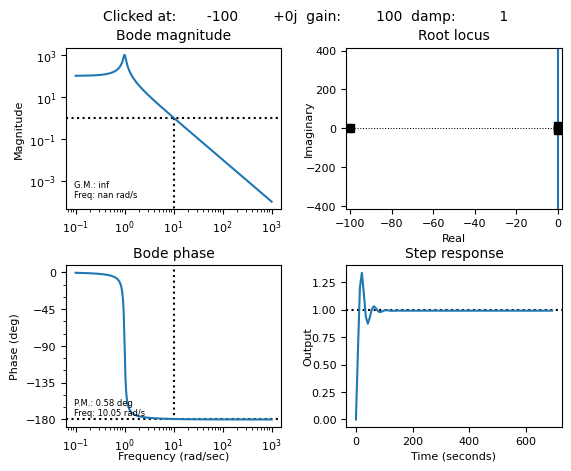

In [13]:
#Exploramos la respuesta del sistema utilizando la
#herramienta rootlocus_pid_designer

#Primero ajustamos la ganancia 'P'
control.rootlocus_pid_designer(plant,deltaK=100)


C:\Users\jcl00\pyenvs\math\Lib\site-packages\control\margins.py:378: RuntimeWarning: invalid value encountered in less_equal
  w_180 = w_180[w180_resp <= 0.]
C:\Users\jcl00\pyenvs\math\Lib\site-packages\control\margins.py:379: RuntimeWarning: invalid value encountered in less_equal
  w180_resp = w180_resp[w180_resp <= 0.]


<LinearIOSystem:sys[128]:['u[0]']->['y[0]']>

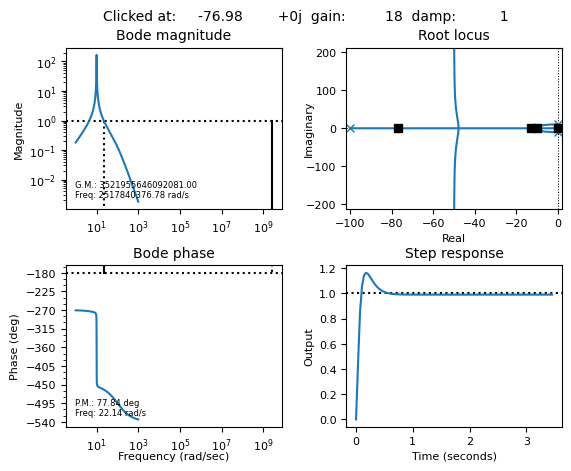

In [14]:
#Luego ajustamos la ganancia 'D'
control.rootlocus_pid_designer(plant,Kp0=100,gain='D',deltaK=18)


<LinearIOSystem:sys[169]:['u[0]']->['y[0]']>

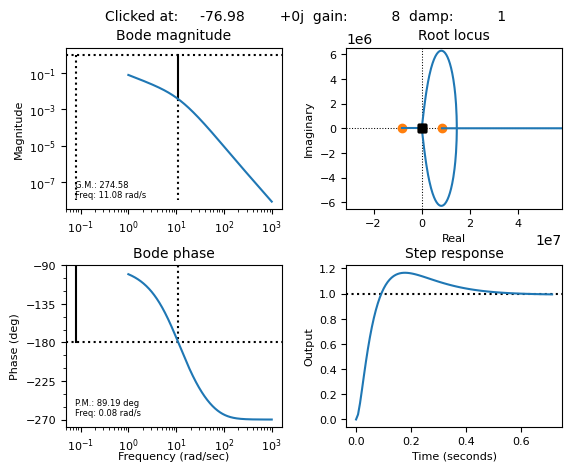

In [15]:
#Luego ajustamos la ganancia 'I'
control.rootlocus_pid_designer(plant,Kp0=100,Kd0=18,gain='I',deltaK=8)


## 4. Programación dinámica

La programación dinámica es una técnica matemática utilizada para resolver problemas de optimización secuencial en los que se toman decisiones a lo largo del tiempo. En el contexto del control de sistemas dinámicos, la programación dinámica se conoce como control óptimo, ya que busca determinar la mejor estrategia de control para optimizar un criterio específico.

La programación dinámica se basa en el principio de Bellman, que establece la relación entre las soluciones óptimas de subproblemas y la solución óptima del problema general. Las ecuaciones fundamentales que describen este principio son las ecuaciones de Bellman. Estas permiten definir el problema de ir del estado $x_0$ al estado $x_f$ aplicando una acción $u$ que minimiza una función de costo $J$.

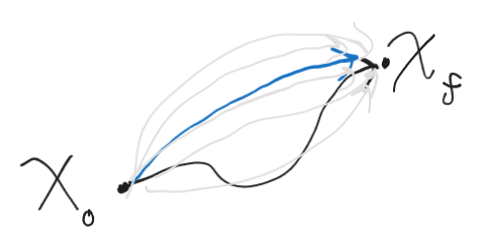


En este caso el problema se expresan como:

$$ J(x(t),u(t),t_0,t_f) = Q(x(t_f),t_f) + \int_{t_0}^{t_f} L(x(\tau),u(\tau)) d\tau $$

Donde se quiere encontrar $u(t)$ entre $t_0$ y $t_f$ que produzcan el costo minimo $V$

$$ V(x(t_0),t_0,t_f)=\min_{u(t)} J(x(t),u(t),t_0,t_f) $$

Esta formulación se caracteriza por dos aspectos fundamentales: la propiedad de optimalidad y la estructura recursiva óptima. La propiedad de optimalidad establece que una política óptima tiene la propiedad aditiva, es decir, cualquier secuencia parcialmente óptima también debe ser parte de una solución globalmente óptima. Por otro lado, la estructura recursiva implica que las soluciones a subproblemas pueden combinarse eficientemente para obtener una solución al problema general. De esta manera se puede descomponer el problema completo subproblemas más simples y se resuelven de manera recursiva.

Respecto al control PID (Proporcional-Integral-Derivativo), que es ampliamente utilizado debido a su simplicidad y eficacia en una variedad de aplicaciones industriales, la programación dinámica ofrece ciertas ventajas.

En la programación dinámica se busca minimizar o maximizar una función objetivo definida, como el consumo energético, el tiempo de respuesta o cualquier otro criterio deseado. En cambio, el PID se centra solamente mantener estable el sistema y reducir errores entre la salida deseada y real.

Los controladores PID necesitan ser ajustados manualmente por para cada aplicación específica, los algoritmos de control óptimo pueden adaptarse automáticamente a cambios en las condiciones operativas.

Se puede dar solución a este tipo de problemas en la librería `control` usando la función  `solve_ocp`. Para esto definimos una función de costo `cost_fun` con lo que se busca minimizar en el problema de control óptimo. En este caso, la función de costo está definida como la diferencia al cuadrado entre un valor deseado y el estado actual del sistema.

Se puede establecer una restricción terminal para los estados finales del sistema mediante `terminal_constraint`. Esta restricción define un rango dentro del cual deben encontrarse los estados finales para considerar que el problema ha sido resuelto con éxito.

Finalmente se llama la función `solve_ocp` la cual plantea y resuelve el problema de control óptimo (OCP) para encontrar las acciones óptimas a tomar en cada instante de tiempo, minimizando así la función de costo definida anteriormente y cumpliendo con las restricciones terminales especificadas.

In [16]:
# Optimal control (Dynamic programming)
def cost_fun(x,u):
    r=[1,0]
    cost=u**2
    return cost

tt=np.linspace(0,0.6,100)
terminal_constraint=control.optimal.state_range_constraint(control.LinearIOSystem(plant),[0.99,-0.01],[1.01,0.01])
out=control.optimal.solve_ocp(control.LinearIOSystem(plant),tt,[0,0],cost_fun,terminal_constraints=terminal_constraint)

Summary statistics:
* Cost function calls: 6321
* Constraint calls: 6644
* System simulations: 1
* Final cost: 0.10798216523525421


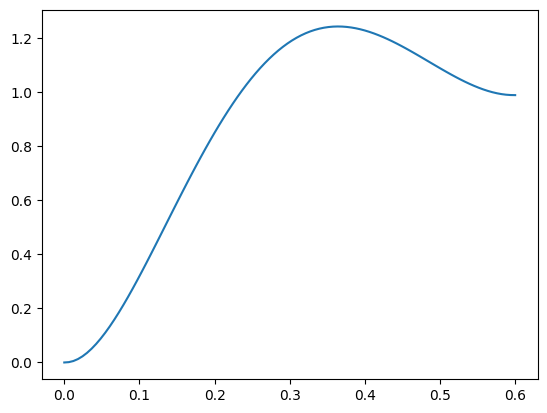

In [18]:
plt.plot(tt,out.states[0,:])

## Ejercicio en clase (Equivale a nota de taller 10):
Utilice la funcion solve_ocp definiendo una funcion de costo que minimice la fuerza de acción
sobre el sistema.

1. Grafique en una misma figura la respuesta del sistema mostrada en la guía y la respuesta del sistema encontrada
en este nuevo caso.
2. Grafique en una misma figura la acción de control realizada sobre el sistema para el cost_fun de la guía
y la acción de control en este nuevo caso.

Presente las gráficas en clase para recibir su nota del taller 10.

